# Workshop 3

After you learn about _regular expressions_ and _data manipulation_, it is momment to validate how many do you learn about __data visualization__.  

## Problem 1

The data for this problem comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location, and this is stored in the file: [assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv](assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv).

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:

- __id__: station identification code
- __date__: date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
- __element__: indicator of element type
    - _TMAX_: Maximum temperature (tenths of degrees F)
    - _TMIN_: Minimum temperature (tenths of degrees F)
- __value__: data value for element (tenths of degrees F)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

Your final output should looks like next one:

![](chris_sketch.png)

### Step 1.1

Load the dataset and transform the data into _Celsius_ (refer to documentation). Then extract all of the rows which have minimum or maximum temperatures, each one in a separate dataframe.

__Hint: when I did this step I had two DataFrame objects, each with ~80,000 entries in it__

In [6]:
import pandas as pd

def fahrenheit_to_celsius(fahrenheit):
    """Converts Fahrenheit to Celsius.

    Args:
        fahrenheit (float): Temperature in Fahrenheit.

    Returns:
        float: Equivalent temperature in Celsius.
    """
    temp_celsius = ((fahrenheit - 32) * 5 / 9)/10
    return temp_celsius

# Get the data
ghcn_df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# Convert the Date column to datetime format and print the first few rows
ghcn_df['Date'] = pd.to_datetime(ghcn_df['Date'])
print("Before convertion:")
print(ghcn_df.head())

# CConvert the temperature values from Fahrenheit to Celsius
ghcn_df['Data_Value'] = ghcn_df['Data_Value'].apply(fahrenheit_to_celsius)

# Filter the DataFrame to get only the rows with the Element column equal to 'TMIN' or 'TMAX'
temp_min_df = ghcn_df[ghcn_df['Element'] == 'TMIN']
temp_max_df = ghcn_df[ghcn_df['Element'] == 'TMAX']

# Print the first few rows of the filtered DataFrames
print("After convertion:")
print(ghcn_df.head())

Before convertion:
            ID       Date Element  Data_Value
0  USW00094889 2014-11-12    TMAX          22
1  USC00208972 2009-04-29    TMIN          56
2  USC00200032 2008-05-26    TMAX         278
3  USC00205563 2005-11-11    TMAX         139
4  USC00200230 2014-02-27    TMAX        -106
After convertion:
            ID       Date Element  Data_Value
0  USW00094889 2014-11-12    TMAX   -0.555556
1  USC00208972 2009-04-29    TMIN    1.333333
2  USC00200032 2008-05-26    TMAX   13.666667
3  USC00205563 2005-11-11    TMAX    5.944444
4  USC00200230 2014-02-27    TMAX   -7.666667


In [7]:
# space for proffessor's tests


### Step 1.2

In order to visualize the data we would _plot_ the __min__ and _max_ data for each day of the year between the years $2005$ and $2014$ across all weather stations. But we also need to find out _when_ the __min__ or __max__ temperature in $2015$ falls below the min or rises above the max for the _previous decade_.

If you did _Step 1.1_ you have _two Series_ objects with _min_ and _max_ times for the years $2005$ through $2015$. You can use Pandas `groupby` to create _max_ and _min_ temperature _Series_ objects across all weather stations for each day of these years, and you can deal with the records for _February 29_ (the leap year) by dropping them.

__Hint: When I finished this step, I had two DataFrame objects, each with exactly 4015 observations in them__

In [8]:
# Filter data between 2005 and 2014, excluding February 29
def filter_data(df, start_year, end_year):
    df_filtered = df[(df['Date'].dt.year >= start_year) & (df['Date'].dt.year <= end_year)]
    df_filtered = df_filtered[df_filtered['Date'].dt.strftime('%m-%d') != '02-29']
    df_filtered['Day_Of_Year'] = df_filtered['Date'].dt.strftime('%m-%d')
    return df_filtered

temp_min_df_2005_2014 = filter_data(temp_min_df, 2005, 2014)
temp_max_df_2005_2014 = filter_data(temp_max_df, 2005, 2014)

# Agroup data by day of year
temp_min_per_day_df = temp_min_df_2005_2014.groupby('Day_Of_Year')['Data_Value'].min().reset_index()
temp_max_per_day_df = temp_max_df_2005_2014.groupby('Day_Of_Year')['Data_Value'].max().reset_index()

# Filter data for 2015
temp_min_df_2015 = filter_data(temp_min_df, 2015, 2015)
temp_max_df_2015 = filter_data(temp_max_df, 2015, 2015)

# Identify broken records
def identify_broken_records(df_2015, df_per_day, comparison):
    merged_df = df_2015.merge(df_per_day, on='Day_Of_Year')
    if comparison == 'min':
        return merged_df[merged_df['Data_Value_x'] < merged_df['Data_Value_y']]
    else:
        return merged_df[merged_df['Data_Value_x'] > merged_df['Data_Value_y']]

broken_min_2015 = identify_broken_records(temp_min_df_2015, temp_min_per_day_df, 'min')
broken_max_2015 = identify_broken_records(temp_max_df_2015, temp_max_per_day_df, 'max')

# Show the results
print(temp_min_per_day_df.head(15))
print(temp_max_per_day_df.head(15))
print(broken_min_2015.head(15))
print(broken_max_2015.head(15))


   Day_Of_Year  Data_Value
0        01-01  -10.666667
1        01-02  -16.611111
2        01-03  -16.611111
3        01-04  -16.277778
4        01-05  -10.111111
5        01-06  -16.555556
6        01-07  -18.777778
7        01-08  -18.111111
8        01-09  -17.222222
9        01-10  -16.000000
10       01-11  -11.944444
11       01-12  -12.500000
12       01-13  -15.666667
13       01-14  -16.555556
14       01-15  -16.888889
   Day_Of_Year  Data_Value
0        01-01    6.888889
1        01-02    5.944444
2        01-03    5.611111
3        01-04    4.111111
4        01-05    5.333333
5        01-06    8.722222
6        01-07   10.277778
7        01-08    9.000000
8        01-09    8.111111
9        01-10    3.777778
10       01-11    6.888889
11       01-12    7.166667
12       01-13    7.500000
13       01-14    6.555556
14       01-15    1.944444
               ID       Date Element  Data_Value_x Day_Of_Year  Data_Value_y
332   USW00094889 2015-08-28    TMIN      1.333333       08

In [9]:
# space for proffessor's tests

### Step 1.3
Now that you have grouped the _daily_ __max__ and __min__ temperatures for each day of the years $2005$ through $2015$, you can separate out the data for $2015$. Then you can use the Pandas `groupby` function to find the __max__ and __min__ of the temperature data for each __day of the year__ for the $2005-2014$ data.

__Hint: At the end of this step I had two DataFrames, one of maximum and the other of minimum values, which each had 365 observations in them. I also had another pair of similar DataFrames but only for the year 2015.__

In [10]:
# Calculate the minimum and maximum temperatures for the period 2005-2014
temp_max_day_year_df = temp_max_df_2005_2014.groupby('Day_Of_Year')['Data_Value'].max().reset_index()
temp_min_day_year_df = temp_min_df_2005_2014.groupby('Day_Of_Year')['Data_Value'].min().reset_index()

# Calculate the minimum and maximum temperatures for 2015
temp_max_per_day_2015_df = temp_max_df_2015.groupby('Day_Of_Year')['Data_Value'].max().reset_index()
temp_min_per_day_2015_df = temp_min_df_2015.groupby('Day_Of_Year')['Data_Value'].min().reset_index()

print(temp_max_day_year_df.head(15))
print(temp_min_day_year_df.head(15))
print(temp_max_per_day_2015_df.head(15))
print(temp_min_per_day_2015_df.head(15))


   Day_Of_Year  Data_Value
0        01-01    6.888889
1        01-02    5.944444
2        01-03    5.611111
3        01-04    4.111111
4        01-05    5.333333
5        01-06    8.722222
6        01-07   10.277778
7        01-08    9.000000
8        01-09    8.111111
9        01-10    3.777778
10       01-11    6.888889
11       01-12    7.166667
12       01-13    7.500000
13       01-14    6.555556
14       01-15    1.944444
   Day_Of_Year  Data_Value
0        01-01  -10.666667
1        01-02  -16.611111
2        01-03  -16.611111
3        01-04  -16.277778
4        01-05  -10.111111
5        01-06  -16.555556
6        01-07  -18.777778
7        01-08  -18.111111
8        01-09  -17.222222
9        01-10  -16.000000
10       01-11  -11.944444
11       01-12  -12.500000
12       01-13  -15.666667
13       01-14  -16.555556
14       01-15  -16.888889
   Day_Of_Year  Data_Value
0        01-01   -1.166667
1        01-02    0.388889
2        01-03    0.388889
3        01-04    0.666667
4

In [11]:
# space for proffessor's tests

### Step 1.4

Now it's time to plot! You need to explore _matplotlib_ in order to plot line graphs of the _min_ and _max_ temperatures for the years $2005$ through $2014$ and to scatter plot __only__ the daily $2015$ temperatures that exceeded those values.

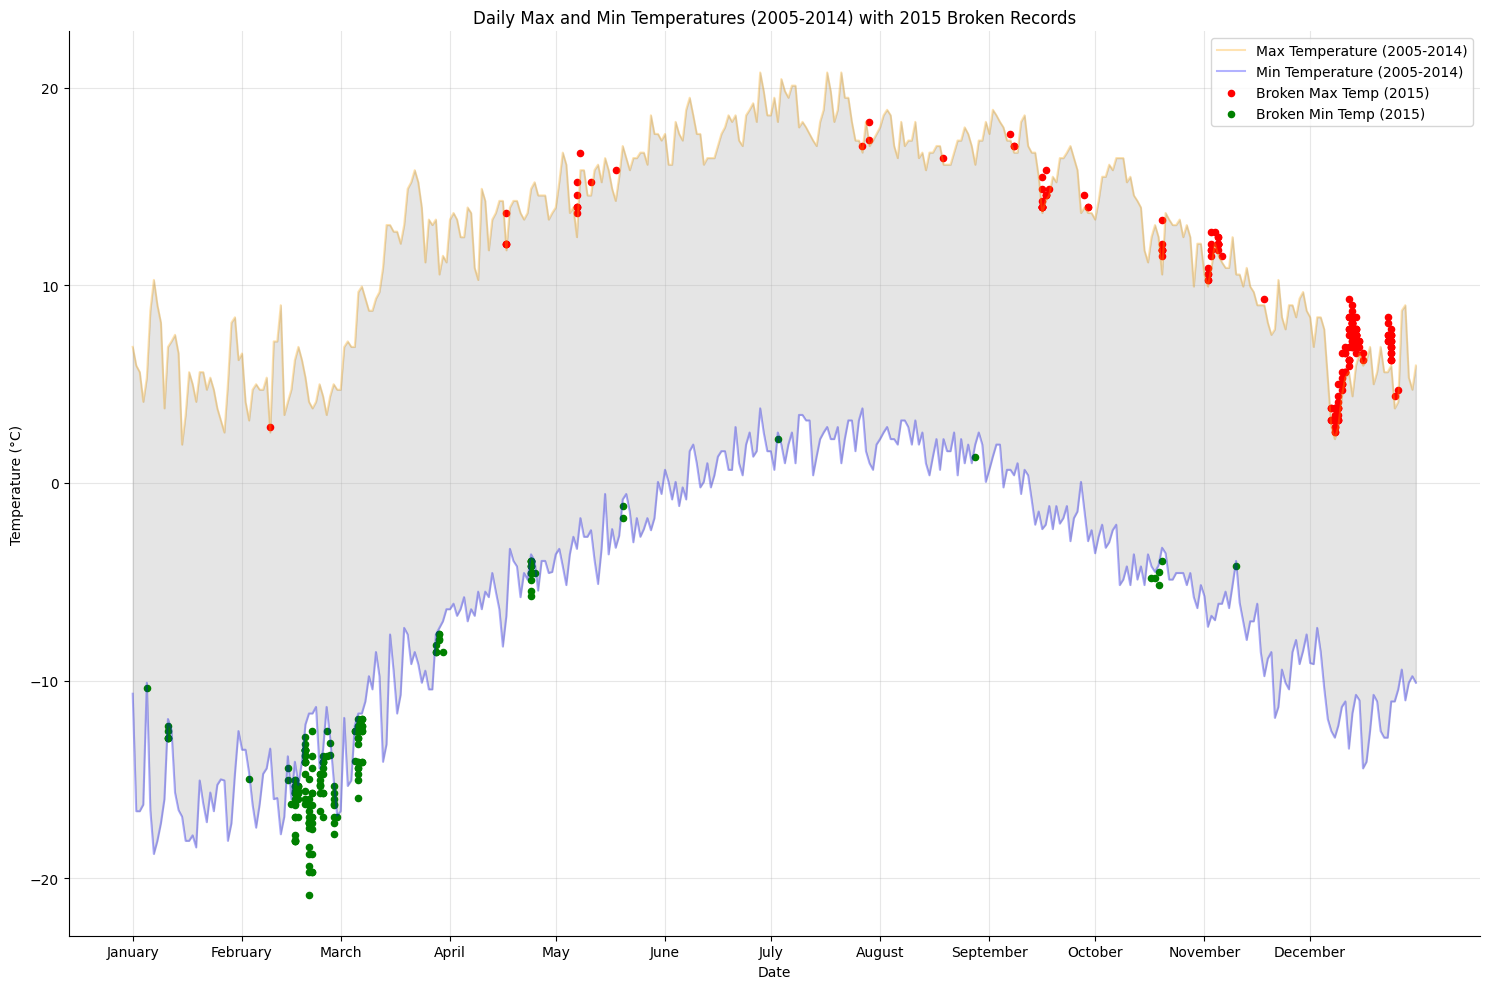

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from calendar import month_abbr

# Prepare the data
lows = temp_min_day_year_df['Data_Value'].to_numpy()
highs = temp_max_day_year_df['Data_Value'].to_numpy()
low_new = lows.flatten()
high_new = highs.flatten()

# Get the broken records
broken_min_2015_idx = broken_min_2015['Day_Of_Year'].apply(lambda x: (pd.to_datetime('2021-' + x).day_of_year) - 1)
broken_max_2015_idx = broken_max_2015['Day_Of_Year'].apply(lambda x: (pd.to_datetime('2021-' + x).day_of_year) - 1)

fig, ax = plt.subplots(figsize=(15, 10))

# Grafith the max and min temperatures
ax.plot(range(len(high_new)), high_new, label='Max Temperature (2005-2014)', color='orange', alpha=0.3)
ax.plot(range(len(low_new)), low_new, label='Min Temperature (2005-2014)', color='blue', alpha=0.3)

# Fill the area between the max and min temperatures
ax.fill_between(range(len(low_new)), low_new, high_new, color='black', alpha=0.1)

# Grafith the broken records
ax.scatter(broken_max_2015_idx, broken_max_2015['Data_Value_x'], color='red', label='Broken Max Temp (2015)', s=20)
ax.scatter(broken_min_2015_idx, broken_min_2015['Data_Value_x'], color='green', label='Broken Min Temp (2015)', s=20)

# Upgrade the plot
ax.set_title('Daily Max and Min Temperatures (2005-2014) with 2015 Broken Records')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()

# Establish the x-axis labels
ax.set_xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

plt.grid(True, alpha=0.3)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()